In [1]:
%matplotlib inline

import collections
import random

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt


random.seed("The lottery is a tax on dumb people")
plt.style.use('blog') # Comment this line to run yourself

C:\Users\osherouse\bin\Miniconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Expected Value

In [2]:
outcomes = pd.DataFrame([
        [1500000000, 292201338],
        [1000000, 11688053.52],
        [50000, 913129.18],
        [100, 36525.17],
        [100, 14494.11],
        [7, 579.76],
        [7, 701.33],
        [4, 91.98],
        [4, 38.32],
        ],
        columns=['value', 'odds'])
outcomes["value_print"] = outcomes["value"].apply("${:,.0f}".format)
outcomes['odds_print'] = outcomes['odds'].apply("1 in {:,.02f}".format)

In [3]:
(outcomes
 [["value_print", "odds_print"]]
 .rename(columns={"value_print": "Outcome",
                  "odds_print": "Odds"})
 )

,Outcome,Odds
0,"$1,500,000,000","1 in 292,201,338.00"
1,"$1,000,000","1 in 11,688,053.52"
2,"$50,000","1 in 913,129.18"
3,$100,"1 in 36,525.17"
4,$100,"1 in 14,494.11"
5,$7,1 in 579.76
6,$7,1 in 701.33
7,$4,1 in 91.98
8,$4,1 in 38.32


In [4]:
print("Expected Value Contribution")

print((outcomes['value'] / outcomes['odds']).to_string())

Expected Value Contribution
0    5.133447
1    0.085557
2    0.054757
3    0.002738
4    0.006899
5    0.012074
6    0.009981
7    0.043488
8    0.104384


In [5]:
expected_value = (outcomes['value'] / outcomes['odds']).sum()
print("${:.02f}".format(expected_value))

$5.45


# Powerplay Expected Value

In [6]:
powerplay = pd.DataFrame(
    [[5, 21],
     [4, 14],
     [3, 3.23],
     [2, 1.75]
    ],
    columns=["multiplier", "odds"]
)
powerplay['odds_print'] = powerplay['odds'].apply("1 in {:,.02f}".format)

In [7]:
(powerplay
 [["multiplier", "odds_print"]]
  .rename(columns={"multiplier": "Multiplier",
                  "odds_print": "Odds"})
 )

,Multiplier,Odds
0,5,1 in 21.00
1,4,1 in 14.00
2,3,1 in 3.23
3,2,1 in 1.75


In [8]:
expected_multiplier = (powerplay['multiplier'] / powerplay['odds']).sum()
expected_value_powerplay = (
    (outcomes['value'].loc[2:] / outcomes['odds']).sum() * expected_multiplier +
    2000000 / outcomes['odds'][1] +
    outcomes['value'][0] / outcomes['odds'][0]
    )
print("Expected Value (Powerplay): ${:.02f}".format(expected_value_powerplay))

Expected Value (Powerplay): $5.91


# Simulation

In [9]:
WHITE = tuple(range(1, 70))
RED = tuple(range(1, 27))
MULTIPLIER = (5,) * 2 + (4,) * 3 + (3,) * 13 + (2,) * 24
# They don't say how many of each ball there are but these give us the right odds

Draw = collections.namedtuple('Draw', ['white', 'red'])

In [10]:
def get_random_draw():
    return Draw(tuple(sorted(random.sample(WHITE, 5))), random.choice(RED))

def get_winnings(ticket, winning):
    correct = sum(1 for i in ticket.white if i in set(winning.white))
    if ticket.red == winning.red:
        return [4, 4, 7, 100, 50000, 1500000000][correct]
    return [0, 0, 0, 7, 100, 1000000][correct]

In [11]:
def apply_powerplay(winnings, multiplier):
    if multiplier is None:
        return winnings
    if winnings < 1000000:
        return winnings * multiplier
    if winnings == 1000000:
        return 2000000
    return winnings

In [12]:
def simulate_play(tickets=1, powerplay=False):
    winning = get_random_draw()
    multiplier = None if not powerplay else random.choice(MULTIPLIER) 
    my_tickets = set()
    while len(my_tickets) < tickets:
        my_tickets.add(get_random_draw())
    return sum(apply_powerplay(get_winnings(i, winning), multiplier)
               for i in my_tickets)

In [13]:
def run_simulation(tickets=1, tries=100000, powerplay=False):
    results = pd.DataFrame({'winnings': list(simulate_play(tickets, powerplay)
                            for i in range(tries))})
    results['cost'] = 3 * tickets if powerplay else 2 * tickets 
    results['profit'] = results['winnings'] - results['cost']
    results['roi'] = results['winnings'] / results['cost'] - 1
    return results, pd.DataFrame([results.median(),
                                  results.mean(),
                                  results.quantile(.05),
                                  results.quantile(.95)
                                 ],
                                 index=["Median Outcome", "Mean Outcome",
                                        "5th Percentile", "95th Percentile"]
                                )

In [14]:
results_one_ticket, summary_one_ticket = run_simulation()

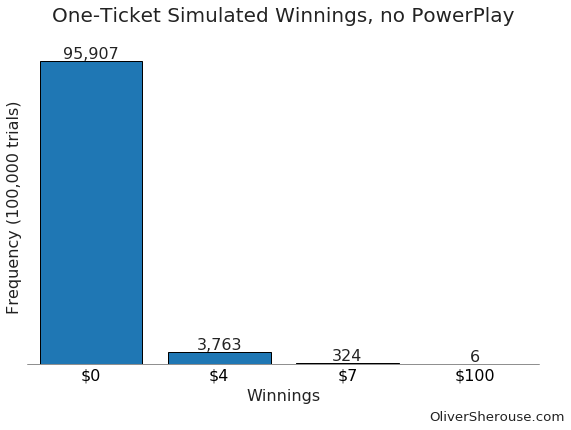

In [29]:
wingroups = results_one_ticket.groupby("winnings").count()['cost']
fig, ax = plt.subplots()
ax.bar(np.arange(len(wingroups)) + .1, wingroups.values)

for i, j in enumerate(wingroups):
    ax.text(i + .5, j, "{:,.0f}".format(j),
            va='bottom', ha='center')

for i in 'top', 'left', 'right':
    ax.spines[i].set_visible(False)
    
ax.set_xticks(np.arange(4) + .5)
ax.set_xticklabels("${:.0f}".format(i) for i in wingroups.index)
ax.set_xlabel("Winnings")

ax.set_yticks([])
ax.set_ylabel("Frequency (100,000 trials)")

ax.set_title("One-Ticket Simulated Winnings, no PowerPlay\n")


for i in 'top', 'left', 'right':
    ax.spines[i].set_visible(False)

fig.set_size_inches(8, 6)
fig.text(1, 0, "OliverSherouse.com",
         va='bottom', ha='right', size='small')
fig.tight_layout()
plt.savefig("one_ticket_no_powerplay.png")

In [16]:
summary_one_ticket

,winnings,cost,profit,roi
Median Outcome,0.0000,2,-2.0000,-1.0000
Mean Outcome,0.1792,2,-1.8208,-0.9104
5th Percentile,0.0000,2,-2.0000,-1.0000
95th Percentile,0.0000,2,-2.0000,-1.0000


In [17]:
results_powerplay, summary_powerplay = run_simulation(powerplay=True)

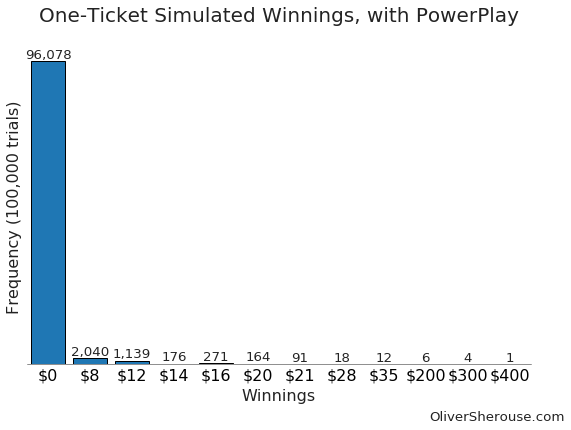

In [18]:
wingroups = results_powerplay.groupby("winnings").count()['cost']
fig, ax = plt.subplots()
ax.bar(np.arange(len(wingroups)) + .1, wingroups.values)

for i, j in enumerate(wingroups):
    ax.text(i + .5, j, "{:,.0f}".format(j),
            va='bottom', ha='center', size='small')

for i in 'top', 'left', 'right':
    ax.spines[i].set_visible(False)
    
ax.set_xticks(np.arange(len(wingroups)) + .5)
ax.set_xticklabels("${:.0f}".format(i) for i in wingroups.index)
ax.set_xlabel("Winnings")

ax.set_yticks([])
ax.set_ylabel("Frequency (100,000 trials)")

ax.set_title("One-Ticket Simulated Winnings, with PowerPlay\n")


fig.set_size_inches(8, 6)
fig.text(1, 0, "OliverSherouse.com",
         va='bottom', ha='right', size='small')
fig.tight_layout()
plt.savefig("one_ticket_with_powerplay.png")

In [19]:
results_powerplay.groupby("winnings").count()['cost']

winnings
0      96078
8       2040
12      1139
14       176
16       271
20       164
21        91
28        18
35        12
200        6
300        4
400        1
Name: cost, dtype: int64

In [20]:
summary_powerplay

,winnings,cost,profit,roi
Median Outcome,0.00000,3,-3.00000,-1.000000
Mean Outcome,0.45703,3,-2.54297,-0.847657
5th Percentile,0.00000,3,-3.00000,-1.000000
95th Percentile,0.00000,3,-3.00000,-1.000000


In [21]:
num_tickets = np.array([1, 2, 5, 10, 15, 20, 25, 30, 40, 50])

tickets_results = []
tickets_powerplay = []
for tickets in num_tickets:
    print("Running with {} tickets".format(tickets), flush=True)
    results = run_simulation(tickets)[1]
    results['tickets'] = tickets
    tickets_results.append(results.set_index('tickets', append=True))
    results = run_simulation(tickets, powerplay=True)[1]
    results['tickets'] = tickets
    tickets_powerplay.append(results.set_index('tickets', append=True))
tickets_results = pd.concat(tickets_results)
tickets_powerplay = pd.concat(tickets_powerplay)

Running with 1 tickets
Running with 2 tickets
Running with 5 tickets
Running with 10 tickets
Running with 15 tickets
Running with 20 tickets
Running with 25 tickets
Running with 30 tickets
Running with 40 tickets
Running with 50 tickets


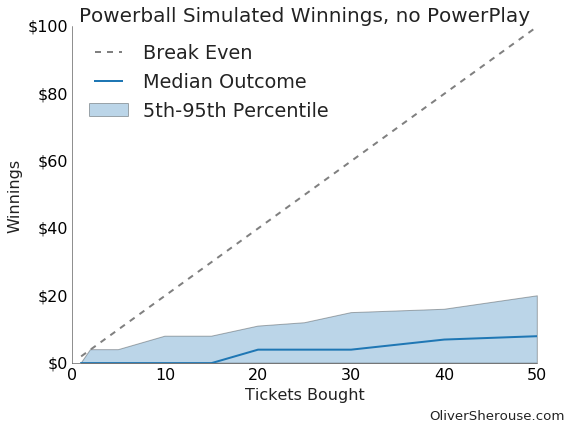

In [30]:
fig, ax = plt.subplots()
ax.plot(num_tickets, tickets_results.xs("Median Outcome")['cost'],
        color='grey', label="Break Even", ls='--')
ax.plot(num_tickets, tickets_results.xs("Median Outcome")['winnings'],
        label="Median Outcome")
ax.fill_between(num_tickets,
                tickets_results.xs("5th Percentile")['winnings'],
                tickets_results.xs("95th Percentile")['winnings'],
                alpha=0.3,
                label='5th-95th Percentile'
               )
ax.set_yticklabels("${:.0f}".format(i) for i in ax.get_yticks())
ax.set_ylabel("Winnings")
ax.set_xlabel("Tickets Bought")

ax.set_title("Powerball Simulated Winnings, no PowerPlay")
ax.legend(loc=2)

fig.set_size_inches(8, 6)

for i in 'top', 'right':
    ax.spines[i].set_visible(False)


fig.text(1, 0, "OliverSherouse.com",
         va='bottom', ha='right', size='small')
fig.tight_layout()
fig.savefig("powerball_no_powerplay.png")

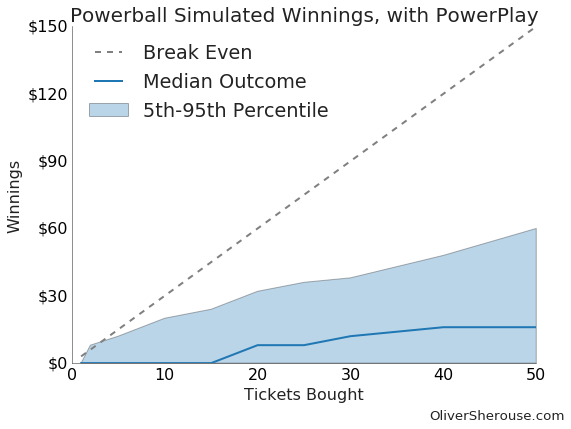

In [31]:
fig, ax = plt.subplots()
ax.plot(num_tickets, tickets_powerplay.xs("Median Outcome")['cost'],
        color='grey', label="Break Even", ls='--')
ax.plot(num_tickets, tickets_powerplay.xs("Median Outcome")['winnings'],
        label="Median Outcome")
ax.fill_between(num_tickets,
                tickets_powerplay.xs("5th Percentile")['winnings'],
                tickets_powerplay.xs("95th Percentile")['winnings'],
                alpha=0.3,
                label='5th-95th Percentile'
               )
ax.set_ybound(0, 150)
ax.set_yticks(range(0, 151, 30))
ax.set_yticklabels("${:.0f}".format(i) for i in ax.get_yticks())
ax.set_ylabel("Winnings")
ax.set_xlabel("Tickets Bought")

ax.set_title("Powerball Simulated Winnings, with PowerPlay")
ax.legend(loc=2)

for i in 'top', 'right':
    ax.spines[i].set_visible(False)


fig.set_size_inches(8, 6)
fig.text(1, 0, "OliverSherouse.com",
         va='bottom', ha='right', size='small')
fig.tight_layout()
fig.savefig("powerball_with_powerplay.png")

In [24]:
tickets_results.xs("Median Outcome").sort_values("profit", ascending=False)

,winnings,cost,profit,roi
tickets,,,,
1,0,2,-2,-1.000000
2,0,4,-4,-1.000000
5,0,10,-10,-1.000000
10,0,20,-20,-1.000000
15,0,30,-30,-1.000000
20,4,40,-36,-0.900000
25,4,50,-46,-0.920000
30,4,60,-56,-0.933333
40,7,80,-73,-0.912500


In [25]:
tickets_powerplay.xs("Median Outcome").sort_values("profit", ascending=False)

,winnings,cost,profit,roi
tickets,,,,
1,0,3,-3,-1.000000
2,0,6,-6,-1.000000
5,0,15,-15,-1.000000
10,0,30,-30,-1.000000
15,0,45,-45,-1.000000
20,8,60,-52,-0.866667
25,8,75,-67,-0.893333
30,12,90,-78,-0.866667
40,16,120,-104,-0.866667


In [26]:
tickets_results.xs("95th Percentile").sort_values("profit", ascending=False)

,winnings,cost,profit,roi
tickets,,,,
2,4,4,0,0.000000
1,0,2,-2,-1.000000
5,4,10,-6,-0.600000
10,8,20,-12,-0.600000
15,8,30,-22,-0.733333
20,11,40,-29,-0.725000
25,12,50,-38,-0.760000
30,15,60,-45,-0.750000
40,16,80,-64,-0.800000


In [27]:
tickets_powerplay.xs("95th Percentile").sort_values("profit", ascending=False)

,winnings,cost,profit,roi
tickets,,,,
2,8,6,2,0.333333
1,0,3,-3,-1.000000
5,12,15,-3,-0.200000
10,20,30,-10,-0.333333
15,24,45,-21,-0.466667
20,32,60,-28,-0.466667
25,36,75,-39,-0.520000
30,38,90,-52,-0.577778
40,48,120,-72,-0.600000
